In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import decode_image
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [ ]:
!ls /kaggle/input/chest-xray-pneumonia-balanced-dataset/

ls: cannot access '/kaggle/input/chest-xray-pneumonia-balanced-dataset/': No such file or directory


In [ ]:
import os

dataset_path = '/kaggle/input/chest-xray-pneumonia-balanced-dataset/'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'val')

In [ ]:
dataset_path

'/kaggle/input/chest-xray-pneumonia-balanced-dataset/'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yusufmurtaza01/chest-xray-pneumonia-balanced-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia-balanced-dataset' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia-balanced-dataset


In [ ]:
n_train_normal, n_train_pneumonia = len(os.listdir(os.path.join(train_path, 'NORMAL'))), len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
n_test_normal, n_test_pneumonia = len(os.listdir(os.path.join(test_path, 'NORMAL'))), len(os.listdir(os.path.join(test_path, 'PNEUMONIA')))
n_val_normal, n_val_pneumonia = len(os.listdir(os.path.join(val_path, 'NORMAL'))), len(os.listdir(os.path.join(val_path, 'PNEUMONIA')))

print(n_train_normal, n_train_pneumonia)
print(n_test_normal, n_test_pneumonia)
print(n_val_normal, n_val_pneumonia)

3400 3400
15 15
850 850


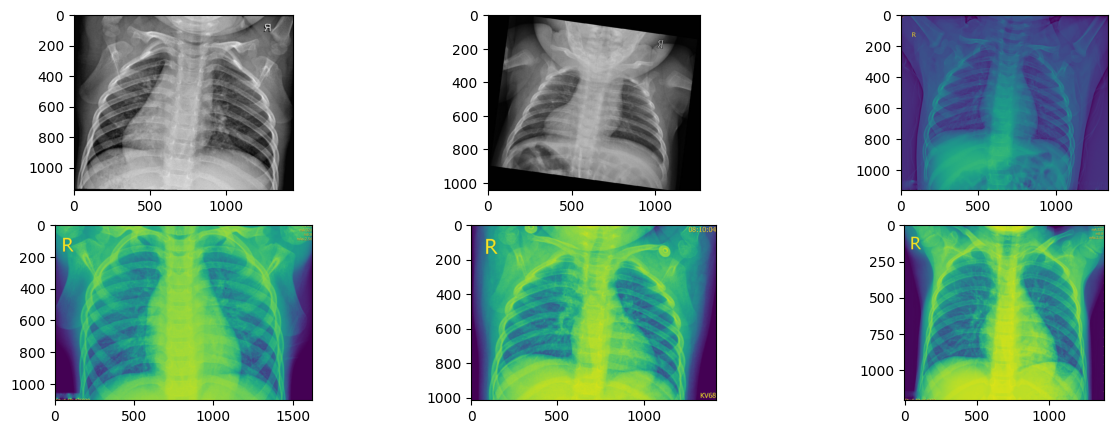

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

images = os.listdir(os.path.join(train_path, 'NORMAL'))[:3]
for i, img in enumerate(images):
    img_path = os.path.join(train_path, 'NORMAL', img)
    img = plt.imread(img_path)
    ax[0, i].imshow(img)

images = os.listdir(os.path.join(train_path, 'PNEUMONIA'))[:3]
for i, img in enumerate(images):
    img_path = os.path.join(train_path, 'PNEUMONIA', img)
    img = plt.imread(img_path)
    ax[1, i].imshow(img)

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self._load_dataset()

    def _load_dataset(self):
        self.images = []
        self.labels = []
        label_types = ['NORMAL', 'PNEUMONIA']
        for label_type in label_types:
            for img_file in os.listdir(os.path.join(self.img_dir, label_type)):
                if img_file.endswith(('.jpg', '.jpeg')):
                    img_path = os.path.join(self.img_dir, label_type, img_file)
                    self.images.append(img_path)
                    self.labels.append(label_types.index(label_type))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        with open(img_path, 'rb') as f:
            image = decode_image(torch.tensor(list(f.read()), dtype=torch.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
size = (380, 380) # resnet

transforms = v2.Compose([
    # v2.Grayscale(num_output_channels=3),
    v2.RandomResizedCrop(size=size, scale=(0.3, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    # v2.Grayscale(num_output_channels=3),
    v2.RandomResizedCrop(size=size, scale=(0.99, 1.0),  antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(train_path, transforms)
test_dataset = ImageDataset(test_path, test_transforms)
val_dataset = ImageDataset(val_path, test_transforms)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

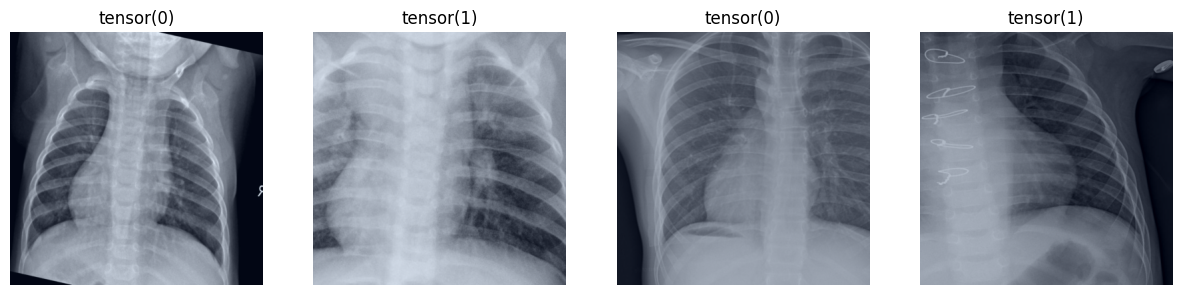

In [ ]:
image, label = next(iter(train_dataloader))

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(image[i].permute(1, 2, 0) * 0.225 + 0.45)
    ax[i].set_title(label[i])
    ax[i].axis('off')

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights


class ResNet50WithEmbeddings(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        base_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        embeddings = torch.flatten(x, 1)
        logits = self.fc(embeddings)

        return logits, embeddings

class ENB4WithEmbeddings(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        base_model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(1792, num_classes, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        embeddings = torch.flatten(x, 1)
        logits = self.fc(embeddings)

        return logits, embeddings

model = ENB4WithEmbeddings()

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 207MB/s]


In [ ]:
# print(efficientnet_b4())

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {"params": model.features.parameters(), "lr": 7e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

In [ ]:
import numpy as np
from tqdm import tqdm

def train_model(model, dataloader, criterion, optimizer, device, progress=False):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    iterator = dataloader

    if progress:
        progress_bar = tqdm(dataloader, desc="Training", leave=False)
        iterator = progress_bar


    for inputs, labels in iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if progress:
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{correct_predictions / total_predictions:.4f}"
            })
        else:
            if np.random.random() < 0.1:
                print(f"[TRAIN] Loss: {loss.item()}, Accuracy: {correct_predictions / total_predictions}")

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, features = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

In [ ]:
num_epochs = 8
unfreeze_step = 1

for p in model.features.parameters():
    p.requires_grad = False

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_dataloader, criterion, optimizer, device, progress=True)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)
    test_loss, test_acc = evaluate_model(model, test_dataloader, criterion, device)

    if epoch == unfreeze_step:
        print('Unfreezing basenet')
        for p in model.features.parameters():
            p.requires_grad = True

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 1/8:
  Train Loss: 0.4008, Train Accuracy: 0.8444
  Validation Loss: 0.2813, Validation Accuracy: 0.8894
  Test Loss: 0.1505, Test Accuracy: 0.9667


Unfreezing basenet
Epoch 2/8:
  Train Loss: 0.3058, Train Accuracy: 0.8797
  Validation Loss: 0.2633, Validation Accuracy: 0.8971
  Test Loss: 0.1006, Test Accuracy: 1.0000


Epoch 3/8:
  Train Loss: 0.1976, Train Accuracy: 0.9238
  Validation Loss: 0.1186, Validation Accuracy: 0.9541
  Test Loss: 0.0518, Test Accuracy: 0.9667


Epoch 4/8:
  Train Loss: 0.1264, Train Accuracy: 0.9543
  Validation Loss: 0.0996, Validation Accuracy: 0.9682
  Test Loss: 0.0030, Test Accuracy: 1.0000


Epoch 5/8:
  Train Loss: 0.1044, Train Accuracy: 0.9621
  Validation Loss: 0.0847, Validation Accuracy: 0.9694
  Test Loss: 0.0022, Test Accuracy: 1.0000


Epoch 6/8:
  Train Loss: 0.0870, Train Accuracy: 0.9719
  Validation Loss: 0.0924, Validation Accuracy: 0.9671
  Test Loss: 0.0010, Test Accuracy: 1.0000


Epoch 7/8:
  Train Loss: 0.0808, Train Accuracy: 0.9728
  Validation Loss: 0.0529, Validation Accuracy: 0.9812
  Test Loss: 0.0116, Test Accuracy: 1.0000


Epoch 8/8:
  Train Loss: 0.0723, Train Accuracy: 0.9740
  Validation Loss: 0.0534, Validation Accuracy: 0.9794
  Test Loss: 0.0206, Test Accuracy: 1.0000


In [ ]:
val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)
print(val_acc)

0.9805882352941176


In [ ]:
import xgboost as xgb
import torch.nn.functional as F


def extract_embeddings(model, dataloader, device):
    model.eval()
    X_list, y_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits, embeddings = model(inputs)
            X_list.append(embeddings.detach().cpu().numpy())
            y_list.append(labels.detach().cpu().numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

def predict_net_proba_and_labels_and_embeddings(model, dataloader, device):
    model.eval()
    probs = []
    y_true = []
    y_pred = []
    embeds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits, embeddings = model(inputs)
            p1 = F.softmax(logits, dim=1)[:, 1]
            pred = torch.argmax(logits, dim=1)

            probs.append(p1.detach().cpu().numpy())
            y_true.append(labels.detach().cpu().numpy())
            y_pred.append(pred.detach().cpu().numpy())
            embeds.append(embeddings.detach().cpu().numpy())

    return (
        np.concatenate(probs, axis=0),
        np.concatenate(y_true, axis=0),
        np.concatenate(y_pred, axis=0),
        np.concatenate(embeds, axis=0)
    )

y_train_probs, y_train, y_train_pred, X_train = predict_net_proba_and_labels_and_embeddings(model, train_dataloader, device)
y_test_probs, y_test, y_test_pred, X_test = predict_net_proba_and_labels_and_embeddings(model, test_dataloader, device)
y_val_probs, y_val, y_val_pred, X_val = predict_net_proba_and_labels_and_embeddings(model, val_dataloader, device)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=512,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_lambda=1.0,
    tree_method="hist",
    early_stopping_rounds=64,
    min_child_weight=5,
    gamma=1.0,
    reg_alpha=1.0
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=128, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

xgb_model.fit(
    X_train_pca, y_train,
    eval_set=[(X_val_pca, y_val)],
    verbose=True,
)

[0]	validation_0-logloss:0.67163
[1]	validation_0-logloss:0.65447
[2]	validation_0-logloss:0.62975
[3]	validation_0-logloss:0.60572
[4]	validation_0-logloss:0.59341
[5]	validation_0-logloss:0.57196
[6]	validation_0-logloss:0.55806
[7]	validation_0-logloss:0.53803
[8]	validation_0-logloss:0.52819
[9]	validation_0-logloss:0.51517
[10]	validation_0-logloss:0.49733
[11]	validation_0-logloss:0.49239
[12]	validation_0-logloss:0.47567
[13]	validation_0-logloss:0.46021
[14]	validation_0-logloss:0.44491
[15]	validation_0-logloss:0.43083
[16]	validation_0-logloss:0.42530
[17]	validation_0-logloss:0.41182
[18]	validation_0-logloss:0.40260
[19]	validation_0-logloss:0.39041
[20]	validation_0-logloss:0.37853
[21]	validation_0-logloss:0.36703
[22]	validation_0-logloss:0.35865
[23]	validation_0-logloss:0.35082
[24]	validation_0-logloss:0.34382
[25]	validation_0-logloss:0.33376
[26]	validation_0-logloss:0.32399
[27]	validation_0-logloss:0.31476
[28]	validation_0-logloss:0.30578
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=64,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=512,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# xgb_model.predict_proba(X_val)[:, 1]

In [ ]:
import torch.nn.functional as F


p_net_train, y_train_true, y_train_pred = y_train_probs, y_train, y_train_pred
p_net_val, y_val_true, y_val_pred = y_val_probs, y_val, y_val_pred

p_xgb_train = xgb_model.predict_proba(X_train_pca)[:, 1]
p_xgb_val = xgb_model.predict_proba(X_val_pca)[:, 1]

In [ ]:
# accuracy_score(y_true=y_val, y_pred=y_val_true)
# y_val = y_val_true

In [ ]:
from sklearn.linear_model import LogisticRegression

meta_X_train = np.stack([p_net_train, p_xgb_train], axis=1)
meta_X_val = np.stack([p_net_val, p_xgb_val], axis=1)
meta = LogisticRegression()
meta.fit(meta_X_train, y_train)

LogisticRegression()

In [ ]:
(meta.predict(meta_X_val) == y_val).mean()

np.float64(0.9811764705882353)

In [ ]:
# X_val, y_val = extract_embeddings(model, val_dataloader, device)
# p_net_val, _ = predict_net_proba(model, val_dataloader, device)
# p_xgb_val = xgb_model.predict_proba(X_val)[:, 1]

# meta_X_val = np.stack([p_net_val, p_xgb_val], axis=1)
p_ens = meta.predict_proba(meta_X_val)[:, 1]

In [ ]:
p_ens.round()

array([0., 0., 0., ..., 1., 0., 1.])

In [ ]:
p_net_val

array([1.4098408e-05, 1.4995729e-03, 9.1103138e-06, ..., 9.9871588e-01,
       1.9998834e-05, 1.0000000e+00], dtype=float32)

In [ ]:
p_xgb_val

array([0.00389364, 0.00195966, 0.0028555 , ..., 0.9896263 , 0.00658771,
       0.99512357], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print('----ResNet----')
all_predictions = p_net_val.round()
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_val, y_pred=all_predictions)))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_val, y_pred=all_predictions)))
print(classification_report(y_val, all_predictions, target_names=['NORMAL', 'PNEUMONIA'], labels=[0, 1]))

print('----XGB----')
all_predictions = p_xgb_val.round()
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_val, y_pred=all_predictions)))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_val, y_pred=all_predictions)))
print(classification_report(y_val, all_predictions, target_names=['NORMAL', 'PNEUMONIA'], labels=[0, 1]))


print('----META----')
all_predictions = p_ens.round()
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_val, y_pred=all_predictions)))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_val, y_pred=all_predictions)))
print(classification_report(y_val, all_predictions, target_names=['NORMAL', 'PNEUMONIA'], labels=[0, 1]))

----ResNet----
accuracy: 0.9800
f1: 0.9800
              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       850
   PNEUMONIA       0.98      0.98      0.98       850

    accuracy                           0.98      1700
   macro avg       0.98      0.98      0.98      1700
weighted avg       0.98      0.98      0.98      1700

----XGB----
accuracy: 0.9812
f1: 0.9812
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       850
   PNEUMONIA       0.99      0.97      0.98       850

    accuracy                           0.98      1700
   macro avg       0.98      0.98      0.98      1700
weighted avg       0.98      0.98      0.98      1700

----META----
accuracy: 0.9812
f1: 0.9812
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       850
   PNEUMONIA       0.99      0.97      0.98       850

    accuracy                           0.98      1700
   m

In [ ]:
import torch
import joblib

# Define filenames
model_filename = "efficientnetb4_model.pth"
xgb_model_filename = "xgboost_model.joblib"
scaler_filename = "scaler.joblib"
pca_filename = "pca.joblib"
meta_classifier_filename = "meta_classifier.joblib"
test_transforms_filename = "test_transforms.pth"

# Save the EfficientNetB4 model (PyTorch)
torch.save(model.state_dict(), model_filename)
print(f"EfficientNetB4 model saved to {model_filename}")

# Save the XGBoost model
joblib.dump(xgb_model, xgb_model_filename)
print(f"XGBoost model saved to {xgb_model_filename}")

# Save the StandardScaler
joblib.dump(scaler, scaler_filename)
print(f"StandardScaler saved to {scaler_filename}")

# Save the PCA
joblib.dump(pca, pca_filename)
print(f"PCA saved to {pca_filename}")

# Save the Meta-classifier (LogisticRegression)
joblib.dump(meta, meta_classifier_filename)
print(f"Meta-classifier saved to {meta_classifier_filename}")

# Save the test transformations
torch.save(test_transforms, test_transforms_filename)
print(f"Test transformations saved to {test_transforms_filename}")

EfficientNetB4 model saved to efficientnetb4_model.pth
XGBoost model saved to xgboost_model.joblib
StandardScaler saved to scaler.joblib
PCA saved to pca.joblib
Meta-classifier saved to meta_classifier.joblib
Test transformations saved to test_transforms.pth
